In [3]:
import networkx as nx
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

%matplotlib inline

In [36]:
def distance(node1,node2):
    '''Simple distance formula between two points'''
    x1 = node1[0]
    x2 = node2[0]
    y1 = node1[1]
    y2 = node2[1]
    return sqrt((x2-x2)**2 + (y2-y1)**2)

def max_distance(points):
    '''Gets the maximum distance between two points in the graph'''
    current = 0
    for node1 in points:
        for node2 in points:
            d = distance(node1,node2) # Find the distance between the two nodes
            if d>current: # if it's a greater distance, store that distance as the greatest
                current=d
    return current


def cost_of_min_flow(G):
    '''Given a graph, it gives the cost of the paths in the max flow min cost over the graph'''
    
    flow_path = nx.max_flow_min_cost(G,'source','sink',weight='cost') # Gets the flow path from source to sink
    beginning = flow_path['source'] # The beginning has the directions for where each cab starts
    
    total_cost = 0
    start_paths = [n[0] for n in beginning.items() if n[1]==1] # each node which the flow_path indicates to go
    paths = []
    for start_node in start_paths: # For each node that a cab goes to in order to start
        path = [start_node]
        curr_node=start_node
        path_cost = 0
        while curr_node!='destination': # Loop through the path until you reach the destination
            next_node = [n for n in flow_path[curr_node].items() if n[1]==1][0][0] # each node the current node travels to
            path_cost += G.edge[curr_node][next_node]['cost'] # Add the cost of the edge from the current node to the next node
            curr_node = next_node # Switch current node to be the node travelled to
            path.append(curr_node)
        total_cost += path_cost # When that node is finished, add it to the total cost and start over
        paths.append(path)
    return total_cost, paths    

def allocation(passengers, destination, complete=False):
    '''
    Given a list of passengers and a destination, gives a graph with a minimum cost (iterating over m')
    passengers is a list of tuples - ID, x, y
    destination is a tuple
    complete=True if we want the passenger inputs to not be ordered
    '''
    G=nx.DiGraph() # Create a directed graph
    
    # The rest of the algorithm closely follows Raga's paper - I quote the steps directly
    
    # Step 1
    # "s and t denote the source and sink vertices, respectively"
    G.add_node("source", type="meta")
    G.add_node("sink", type="meta")
    
    # Step 2
    # For each passenger/pickup location u ∈ N , we create two vertices and an edge: an
    # entry vertex u_in, an exit vertex u_out, and an edge of cost 0 and capacity 1 directed
    # from u_in to u_out. We also create a vertex n+1 corresponding to the dropoff location.
    i = 1
    for passenger in passengers:
        # {}in.format(x) will give the node the name xin, for any integer x
        G.add_node("{}in".format(i), number=i, x=passenger[0], y=passenger[1], type="passenger in")
        G.add_node("{}out".format(i),number=i, x=passenger[0], y=passenger[1], type="passenger out")
        G.add_edge("{}in".format(i), "{}out".format(i), cost=0, capacity=1)
        i+=1
    G.add_node("destination", x=destination[0], y=destination[1], type="destination")
    
    # Step 3
    # We create n edges, one each of cost 0 and capacity 1 from the source vertex s to each
    # of the entry vertices u_in, u ∈ N.
    for node in G.nodes(data=True):
        if node[1]['type']=="passenger in":
            G.add_edge("source", node[0], cost=0, capacity=1)
    
    # Calculating L
    # passengers + [destination] is the concatonation of the two lists
    L = len(passengers)*max_distance(passengers + [destination]) + 1 
    
    
    # Step 4
    # We create n edges, one each of cost SuD and capacity 1 from each 
    # of the exit vertices uout, u ∈ N, to the dropoff vertex n + 1
    for node in G.nodes(data=True):
        if node[1]['type']=="passenger out":
            cost = distance(destination, (node[1]['x'],node[1]['y'])) # Calculating SuD
            node_name = node[0]
            G.add_edge(node_name,"destination", cost=cost-L, capacity=1) # Creating the edge with that cost
    
    # Step 5
    # To encode the pickup order, for each 1 ≤ u < v ≤ n we create an edge of cost
    # (SuSv − L) and capacity 1 directed from u_out to v_in, where L is a sufficiently large
    # number satisfying L > 2*max [u,v∈N∪{n+1} SuSv].
    
    
    for u in range(1,len(passengers)+1): # For each u
        if complete: # If we want a complete graph we will do every v, otherwise just v>u
            start = 1
        else: 
            start = u+1
        for v in range(start, len(passengers)+1):
            if u!=v:
                G.add_edge("{}out".format(u), "{}in".format(v), 
                           cost=distance(passengers[u-1], passengers[v-1])-L, capacity=1) 
    
    
    # Step 6
    # We add a final edge of cost 0 and capacity m′ from the dropoff vertex n + 1 to the
    # sink vertex t, thereby limiting the maximum flow in the network to m′ units.
    
    # In this implementation, we make n copies of this graph, and give each one an m' from i to n
    possible_graphs = [G.copy() for i in range(len(passengers))]
    for i, pg in enumerate(possible_graphs):
        pg.add_edge("destination", "sink", cost=0, capacity=i+1) # All the different m' values
    
    # Now over these graphs we have to find the one with the lowest cost in the min cost max flow algorithm
    # Aka which m' gives the lowest cost
    min_cost = float('inf')
    min_flow_graph = None
    costs = []
    paths = []
    for pg in possible_graphs:
        # For each possible graph, calculate the cost. If the cost is less than previous graphs, store it
        c = cost_of_min_flow(pg)[0]
        paths.append(cost_of_min_flow(pg)[1])
        costs.append(c)
        if c<min_cost:
            min_cost=c
            min_flow_graph=pg
    print costs
    print paths
    return min_flow_graph # return the minimum graph

In [37]:
# This example creates a graph where the players are at positions (1,1), (-1,1), (-1,-1), (1,-1) and destination (0,0)
#G = allocation([(2,2), (1,1), (1,0), (1,-1), (3,1), (3,0), (3,-1)], (2,-2))
G = allocation([(1,1), (0,1), (-1,1), (-1,0), (-1,-1), (0,-1), (1,-1), (1,0)], (0,0))

[-133.0, -134.0, -134.0, -134.0, -133.0, -132.0, -131.0, -130.0]
[[['1in', '1out', '2in', '2out', '3in', '3out', '4in', '4out', '5in', '5out', '6in', '6out', '7in', '7out', '8in', '8out', 'destination']], [['1in', '1out', '2in', '2out', '3in', '3out', '4in', '4out', 'destination'], ['5in', '5out', '6in', '6out', '7in', '7out', '8in', '8out', 'destination']], [['1in', '1out', '2in', '2out', '3in', '3out', '4in', '4out', 'destination'], ['8in', '8out', 'destination'], ['5in', '5out', '6in', '6out', '7in', '7out', 'destination']], [['1in', '1out', '2in', '2out', '3in', '3out', 'destination'], ['8in', '8out', 'destination'], ['5in', '5out', '6in', '6out', '7in', '7out', 'destination'], ['4in', '4out', 'destination']], [['1in', '1out', '2in', '2out', '3in', '3out', 'destination'], ['6in', '6out', 'destination'], ['8in', '8out', 'destination'], ['5in', '5out', '7in', '7out', 'destination'], ['4in', '4out', 'destination']], [['1in', '1out', '2in', '2out', '3in', '3out', 'destination'], ['7in'

In [15]:
# All the nodes in the graph

G.nodes(data=True)

[('1in', {'number': 1, 'type': 'passenger in', 'x': 2, 'y': 2}),
 ('6out', {'number': 6, 'type': 'passenger out', 'x': 3, 'y': 0}),
 ('source', {'type': 'meta'}),
 ('7in', {'number': 7, 'type': 'passenger in', 'x': 3, 'y': -1}),
 ('2out', {'number': 2, 'type': 'passenger out', 'x': 1, 'y': 1}),
 ('destination', {'type': 'destination', 'x': 2, 'y': -2}),
 ('6in', {'number': 6, 'type': 'passenger in', 'x': 3, 'y': 0}),
 ('5in', {'number': 5, 'type': 'passenger in', 'x': 3, 'y': 1}),
 ('2in', {'number': 2, 'type': 'passenger in', 'x': 1, 'y': 1}),
 ('7out', {'number': 7, 'type': 'passenger out', 'x': 3, 'y': -1}),
 ('4in', {'number': 4, 'type': 'passenger in', 'x': 1, 'y': -1}),
 ('1out', {'number': 1, 'type': 'passenger out', 'x': 2, 'y': 2}),
 ('4out', {'number': 4, 'type': 'passenger out', 'x': 1, 'y': -1}),
 ('sink', {'type': 'meta'}),
 ('3out', {'number': 3, 'type': 'passenger out', 'x': 1, 'y': 0}),
 ('3in', {'number': 3, 'type': 'passenger in', 'x': 1, 'y': 0}),
 ('5out', {'number'

In [16]:
# All the edges in the graph
G.edges(data=True)

[('1in', '1out', {'capacity': 1, 'cost': 0}),
 ('6out', '7in', {'capacity': 1, 'cost': -28.0}),
 ('6out', 'destination', {'capacity': 1, 'cost': -27.0}),
 ('source', '1in', {'capacity': 1, 'cost': 0}),
 ('source', '7in', {'capacity': 1, 'cost': 0}),
 ('source', '6in', {'capacity': 1, 'cost': 0}),
 ('source', '5in', {'capacity': 1, 'cost': 0}),
 ('source', '2in', {'capacity': 1, 'cost': 0}),
 ('source', '4in', {'capacity': 1, 'cost': 0}),
 ('source', '3in', {'capacity': 1, 'cost': 0}),
 ('7in', '7out', {'capacity': 1, 'cost': 0}),
 ('2out', '7in', {'capacity': 1, 'cost': -27.0}),
 ('2out', 'destination', {'capacity': 1, 'cost': -26.0}),
 ('2out', '6in', {'capacity': 1, 'cost': -28.0}),
 ('2out', '5in', {'capacity': 1, 'cost': -29.0}),
 ('2out', '4in', {'capacity': 1, 'cost': -27.0}),
 ('2out', '3in', {'capacity': 1, 'cost': -28.0}),
 ('destination', 'sink', {'capacity': 2, 'cost': 0}),
 ('6in', '6out', {'capacity': 1, 'cost': 0}),
 ('5in', '5out', {'capacity': 1, 'cost': 0}),
 ('2in', '

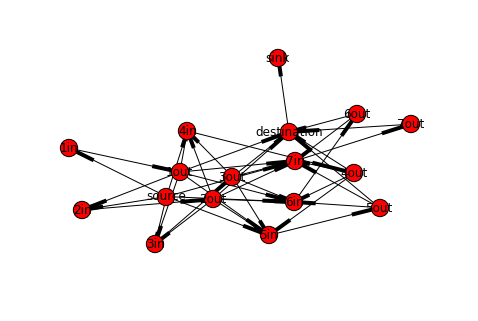

In [17]:
# Drawing of the graph (not very well done)
nx.draw_graphviz(G, with_labels=True)

In [18]:
# The path that should be taken
# Starting from the source, a 1 in the node in the dictionary means send 1 cab there
nx.max_flow_min_cost(G,'source','sink',weight='cost')

{'1in': {'1out': 1},
 '1out': {'2in': 1,
  '3in': 0,
  '4in': 0,
  '5in': 0,
  '6in': 0,
  '7in': 0,
  'destination': 0},
 '2in': {'2out': 1},
 '2out': {'3in': 0, '4in': 0, '5in': 1, '6in': 0, '7in': 0, 'destination': 0},
 '3in': {'3out': 1},
 '3out': {'4in': 1, '5in': 0, '6in': 0, '7in': 0, 'destination': 0},
 '4in': {'4out': 1},
 '4out': {'5in': 0, '6in': 0, '7in': 0, 'destination': 1},
 '5in': {'5out': 1},
 '5out': {'6in': 1, '7in': 0, 'destination': 0},
 '6in': {'6out': 1},
 '6out': {'7in': 1, 'destination': 0},
 '7in': {'7out': 1},
 '7out': {'destination': 1},
 'destination': {'sink': 2},
 'sink': {},
 'source': {'1in': 1,
  '2in': 0,
  '3in': 1,
  '4in': 0,
  '5in': 0,
  '6in': 0,
  '7in': 0}}

In [38]:
# The cost of that path
cost_of_min_flow(G)

(-134.0,
 [['1in', '1out', '2in', '2out', '3in', '3out', '4in', '4out', 'destination'],
  ['5in', '5out', '6in', '6out', '7in', '7out', '8in', '8out', 'destination']])